# Prevendo a cotação de criptomoedas em tempo real

Neste mini projeto o objetivo será construir um modelo de Machine Learning capaz de prever a cotação de criptomoedas. Usaremos dados sobre o Bitcoin, mas você poderá estender o projeto para outras criptomoedas se desejar.

Bitcoin é a criptomoeda mais antiga e conhecida, lançada pela primeira vez como código aberto em 2009 pelo anônimo Satoshi Nakamoto. 

O  Bitcoin  serve  como  um  meio  descentralizado  de  troca   digital,  com  transações verificadas  e  registradas  em  um  livro  público  distribuído  (a Blockchain)  sem  a  necessidade  de uma autoridade de manutenção de registros ou intermediário central. 

Os  blocos  de  transação  contêm  um  hash  criptográfico  SHA-256  de  blocos  de  transação anteriores e, portanto, são "encadeados" juntos, servindo como um registro imutável de todas as transações que já ocorreram. 

Usaremos dados históricos de cotação do Bitcoin de 2011 a 2021. Como o ano de 2022 foi bem atípico para o Bitcoin, optamos por não usar dados desse ano. Você poderá incluir dados de 2022 se desejar e treinar novamente o modelo de Machine Learning.

O dataset está sendo fornecido a você e os dados foram extraídos do site: 
https://bitcoincharts.com/charts/

Ao acessar o web site você pode receber mensagem de que é um site inseguro. Isso se deve  ao  certificado  digital  expirado.  Sempre  tome  cuidado  ao  acessar  sites  com  esse  tipo de mensagem, mas esse site em específico não apresenta perigo. De qualquer forma, o dataset está sendo fornecido.


O arquivo CSV contém dadosde 2011 a 2021, com registros OHLC (Open, High, Low, Close)da cotação do Bitcoin, Volume em BTC e Volume na moeda (nesse caso o dólar). A última coluna indica opreço ponderado do Bitcoin. 

Os “carimbos”de data/hora (timestamp) estão em hora Unix. Timestamps sem nenhuma negociação ou atividade têm seus campos de dados preenchidos com NaNs. Se estiver faltando um carimbo de data/hora ou se houver saltos, isso pode ser porque a Exchange estava inativa, a Exchange não existia ou algum outro erro técnicoocorreu na coleta dos dados.

Com  base  em  dados  históricos  de  cotação  do  Bitcoin,  nosso  modelo  deve  ser  capaz  de prever a cotação do Bitcoin em tempo real a partir de novos dados de entrada.Este projeto pode ser  estendido  para  qualquer  outro instrumento  financeiro  que  tenha  dados  de  cotação  diária disponível.

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.7


In [2]:
# Instala o findspark
# !pip install -q findspark

# Importa o findspark e inicializa
import findspark
findspark.init()

In [3]:
# Imports
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
# Formatação das saídas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Lucas Castro" --iversions

Author: Lucas Castro

numpy     : 1.20.3
pyspark   : 3.3.0
pandas    : 1.3.4
matplotlib: 3.4.3
seaborn   : 0.11.2
sys       : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
findspark : 2.0.1



## Preparando o Ambiente Spark

O Apache Spark pode ser usado sempre que os requerimentos abaixo fizerem parte de um projeto de Ciência de Dados:
 - Integração de dados e ETL
 - Análises interativas e manipulação de grandes massas de dados
 - Computação em batch de alta performance
 - Análises avançadas e Machine Learning
 - Processamento de dados em tempo real
 
**Como conectamos no Cluster?**

Para trabalhar com o Apache Spark, primeiro devemos conectar no cluster Spark (seja um pseudo-cluster de uma única máquina,seja em um cluster de milhares de máquinas). A conexãoé feita criando um SparkContext.

Um SparkContext representa a conexão com um cluster Spark e pode ser usado para criar RDDs(Datasets Distribuídos), acumuladores e variáveis de broadcast nesse cluster.
 
Apenas um SparkContext deve estar ativo por JVM. Você deve pararo SparkContext ativo antes de criar um novo.

Com o contexto criado, podemos então criar uma sessão Spark. SparkSessioné o ponto de entrada para o SparkSQL. 

Você cria uma SparkSession usando o método Builder(),que dá acesso à API do Builder que você usa para configurar a sessão.

Uma vez criada a sessão, SparkSession permite criar um DataFrame, criar um Dataset, acessar serviços SparkSQL (por exemplo, ExperimentalMethods, ExecutionListenerManager, UDFRegistration),  executar  uma  consulta  SQL,  carregar  uma  tabela  e  o  último,mas  não menos  importante,acessar  a  interface  DataFrameReader  para  carregar  um conjunto  de dados do formato de sua escolha.

Você pode ter quantas SparkSessions quiser em um único aplicativo Spark. O caso de uso  comum  é  manter  as  entidades  relacionais  separadas  logicamente  em  catálogos  por SparkSession.

No final, você interrompe uma SparkSession usando o método stop().


In [6]:
# Definindo semente  aletória (seed) para reprodutibilidade do notebook
rnd_seed= 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [7]:
# Criando o SPARK CONTEXT
sc = SparkContext(appName = "Mini-Projeto3")

22/09/12 17:50:03 WARN Utils: Your hostname, pcastr resolves to a loopback address: 127.0.1.1; using 192.168.0.20 instead (on interface enp3s0)
22/09/12 17:50:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/12 17:50:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
# Criando a sessão Spark
spark_session = SparkSession.Builder().getOrCreate()

In [9]:
# Visualiza o objeto spark_session
spark_session

In [10]:
# Carregando Dados 
df_spark = spark_session.read.csv('dados/dataset.csv', header = 'true', inferSchema= 'true')

In [11]:
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [12]:
# Visualiza os dados 
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [13]:
# Visualiza os metadados 
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [14]:
# Verifica o número de linhas
df_spark.count()

4856600

## DataFrames no Apache Spark Para Ciência de Dados em Grande Escala

No Spark, um DataFrame é uma coleção distribuída de dados organizados em colunas nomeadas. É conceitualmente equivalente a uma tabela em um banco de dados relacional ou um dataframeem R/Python, mas com otimizações mais ricase para ambiente distribuído. 

Os DataFrames podem ser construídos a partir de uma ampla variedade de fontes, como: arquivos de dados estruturados, tabelas no Hive, bancos de dados externos ou RDDs.

Uma vez criados, os DataFrames fornecem uma estrutura de dados específica para manipulação de dados distribuídos. 

Semelhante  aos  RDDs,  os  DataFrames  são  avaliados  lentamente.  Ou  seja,  a computação só acontece quandouma ação (por exemplo, exibir resultado, salvar saída) é necessária.  Isso  permite  que  suas  execuções  sejam otimizadas. Todas  as  operações  do DataFrame também são paralelizadas automaticamente e distribuídas em clusters.

## RDD's - Resilient Distributed Datasets

RDD é uma coleção de objetos, distribuída e imutável. Cada conjunto de dados no RDD é dividido em partições lógicas, que podem ser computados em diferentes nodes do cluster. 

Os RDDs são imutáveis. Ainda que aparentemente seja possível modificar um RDD com uma transformação, na verdade o resultado dessa transformação é um novoRDD, sendo que o original permanece intocável.

![img](imagens/rdd.png)

Formalmente, um RDD é uma coleção de objetos read-only, ou seja, uma vez criado um RDD ele é apenas para leitura. RDDs podem ser criados a partir de arquivos locais, HDFS, bancos de dados relacionais ou não relacionais ou mesmo a partir de outros RDDs. RDD é um conjunto de elementos tolerante a falhas e que pode ser operado em paralelo.

Existem 2 formas de criar o RDD: 

   - Paralelizando uma coleção existente (função sc.parallelize)
   - Referenciando um dataset externo (HDFS, RDBMS, NoSQL, S3)

As RDD’s são a essência do funcionamento do Spark. Com o conceito de RDD, o Spark armazena os resultados intermediários em memória, permitindo que operações iterativas que precisam acessar os dados diversas vezes, possam recorrer a memória do computador e não ao disco. Os dados serão gravados em disco apenas ao fim do processo ou se durante o processo, não houver memória disponível. Lembre que estamos falando aqui de cluster de compuatdores, com Terabytes de memória RAM quando se combina a memória de cada node do cluster.

## Transformações e ações 

Transformações são “operações preguiçosas” (lazy operations) executadas sobre os RDD’s e que criam um ou mais RDD’s.

Dizemos que as transformações são operações lazy, porque elas não são executadas imediatamente, mas sim no momento em que as operações de ação são executadas.

![img](imagens/transformacao.png)

Após executar operações de Transformação no RDD, o RDD resultante será diferente do RDD original e poderá ser menor (se usadas as funções filter, count, distinct, sample) ou maior (se usadas as funções flatMap, union, cartesian).

Algumas operações de Tranformação podem ser colocadas no que o Spark chama de Pipeline, que é um encadeamento de transformações visando aumentar a performance.

Lista com todas as operações de Transformação:
https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations

Ações são operações executadas sobre os RDD’s que geram um resultado. Ações são  operações  síncronas  mas  podemos  usar  a  função  AsyncRDDActions()  para  tornar  as operações assíncronas. 


Podemos  pensar  nas  ações  como  válvulas.  Os  dados  estão  prontos  para  serem processados  e  operações  de transformação  já  foram  definidas,  mas  somente  quando abrirmos  as  válvulas,  ou  seja,  executarmos  as  ações,  o  processamento  será  realmente iniciado.

Lista com todas as operações de Ação: https://spark.apache.org/docs/latest/rdd-programming-guide.html#actions

Resumindo: As ”Ações” aplicam as ”Transformações” nos RDD’s e retornam resultado.

![img](imagens/acao.png)

Tramsformações são operações similares as técnicas de carregamento em modernos engines de dados como presentes no Microsoft.NET por exemplo. Cada transformação é uma operação no RDD, que gera outro RDD (lembre, o RDD é imutável). Nenhuma transformação é  realmente  realizada  até  que  se  chame  uma  ação  para  a  RDD  (lazy  evaluation).  As ações aplicam as transformações nas RDD’s e retornam resultado.

O diagrama abaixo mostra algumas das principais funções de trans
formação e ação:

![img](imagens/acao_trans.png)

DataFrames  no  Spark  se  comportam  de  forma  muito  similar  aos  RDDs,  sendo  que DataFrames são objetos mutáveis.

## Data Wrangling com SparkSQL

In [15]:
# Cria uma tabela temporária a partir do dataframe
# As tabelas temporárias são úteis quando você deseja que o conjunto de resultados fique visível 
# para todas as outras sessões Spark
df_spark.createOrReplaceTempView('dados_bitcoin') 

In [16]:
# Executa uma consulta SQL
df_bitcoin = spark_session.sql("select *, from_unixtime(Timestamp) as `dateTime` from dados_bitcoin")

In [17]:
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [18]:
# Visualiza os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 04:52:00|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 05:15:00|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 05:16:00|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 05:17:00|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 05:18:00|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 05:19:00|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 05:20:00|


In [19]:
# Remove valores NA (não faz sentido qualquer tratamento aqui, pois todas as colunas de cotações estão como NA)
df_bitcoin = df_bitcoin.dropna('any')

In [20]:
# Visualiza os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 04:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 12:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 13:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 14:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 01:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 12:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 19:45:00|


In [21]:
# Número de registros
df_bitcoin.count()

3613769

In [22]:
# Vamos renomear algumas colunas para facilitar a manipulação dos dados
df_bitcoin = df_bitcoin.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [23]:
# Visualiza
df_bitcoin.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 04:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 12:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 13:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 14:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 01:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 12:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|       10.1|        50.5|           5.0|2012-01-01 19:45:00|
|1325534640| 5.0| 5.0| 5.0|  5.0|     19.048|       95.24|  

> A coluna dateTime fornece os detalhes da data da cotação. Vamos separar os elementos da data em diferentes colunas.

In [24]:
# Vamos dividir o dataframe extraindo data
df_data = df_bitcoin.withColumn("date", split(col("dateTime")," ").getItem(0))

In [25]:
type(df_data)

pyspark.sql.dataframe.DataFrame

In [26]:
# Vamos dividir o dataframe extraindo tempo
df_data = df_data.withColumn("time", split(col("dateTime")," ").getItem(1))

In [27]:
# Schema
df_data.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [28]:
# Visualiza os dados
df_data.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 04:52:00|2011-12-31|04:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 12:50:00|2011-12-31|12:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 13:59:00|2011-12-31|13:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 14:00:00|2011-12-31|14:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 01:16:00|2012-01-01|01:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 12:2

In [29]:
# Vamos dividir o dataframe extraindo a hora
df_data_hora = df_data.withColumn("hour", split(col("time"),":").getItem(0))

In [30]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [31]:
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 04:52:00|2011-12-31|04:52:00|  04|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 12:50:00|2011-12-31|12:50:00|  12|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 13:59:00|2011-12-31|13:59:00|  13|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 14:00:00|2011-12-31|14:00:00|  14|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 01:16:00|2012-01-01|01:16:00|  01|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|   

In [32]:
# Vamos ajustar o formato da data para extrair o dia da semana
df_data_hora = df_data_hora.withColumn("date", df_data_hora["date"].cast(DateType())).withColumn("hour", df_data_hora["hour"].cast(DoubleType())).withColumn("dateTime", df_data_hora["dateTime"].cast(DateType()))


In [33]:
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|04:52:00| 4.0|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|12:50:00|12.0|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|13:59:00|13.0|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|14:00:00|14.0|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|01:16:00| 1.0|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01|2012-01-01|12:28:00|12.0|
|132545790

In [34]:
# Vamos extrair o dia da semana
df_data_hora = df_data_hora.withColumn('day_of_week', dayofweek(df_data_hora.date))

In [35]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [36]:
# Vamos extrair o ano da cotação
df_data_hora_ano = df_data_hora.withColumn("year", split(col("date"),"-").getItem(0))

In [37]:
df_data_hora_ano.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|04:52:00| 4.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|12:50:00|12.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|13:59:00|13.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|14:00:00|14.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|01:16:00| 1.0|  

In [38]:
# Converte o dataframe do Spark para o Pandas. 
# Por quê? Porque isso vai facilitar a análise exploratória de dados.
df_pandas = df_data_hora_ano.toPandas()

In [39]:
type(df_pandas)

pandas.core.frame.DataFrame

In [40]:
# Obtendo os valores individuais para usar nos gráficos
hour = df_pandas["hour"].values.tolist()
weighted_price = df_pandas["Weighted_Price"].values.tolist()
volume_BTC = df_pandas["VolBTC"].values.tolist()
date_of_week = df_pandas["day_of_week"].values.tolist()
year = df_pandas["year"].values.tolist()

In [41]:
df_pandas.head()

,Timestamp,Open,High,Low,Close,VolBTC,VolCurrency,Weighted_Price,dateTime,date,time,hour,day_of_week,year
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011-12-31,04:52:00,4.0,7,2011
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011-12-31,12:50:00,12.0,7,2011
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31,2011-12-31,13:59:00,13.0,7,2011
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011-12-31,14:00:00,14.0,7,2011
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012-01-01,01:16:00,1.0,1,2012


## Análise Exploratória

<AxesSubplot:>

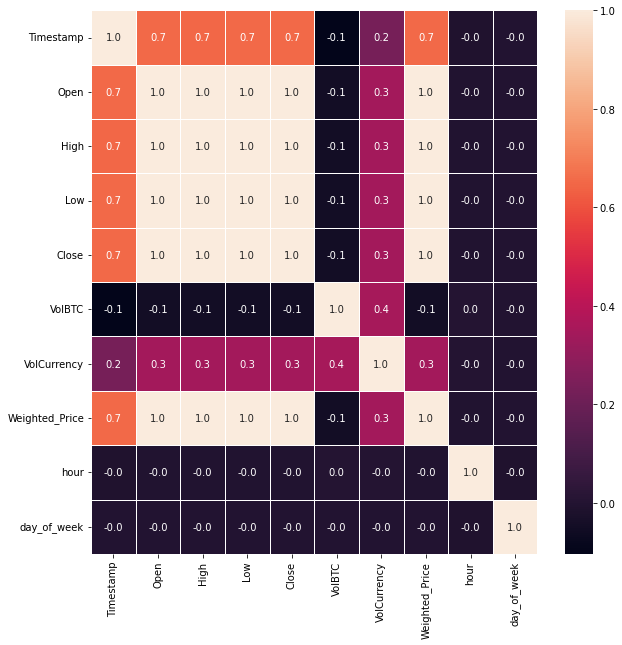

In [42]:
# Heatmap para visualizar a correlação
corr = df_pandas.corr()
f,ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, annot = True, linewidths = .5, fmt = '.1f', ax = ax)

> Idealmente queremos alta correlação entre as variáveis de entrada e a variável de saída e baixa correlação entre as variáveis de entrada!

<Figure size 864x360 with 0 Axes>

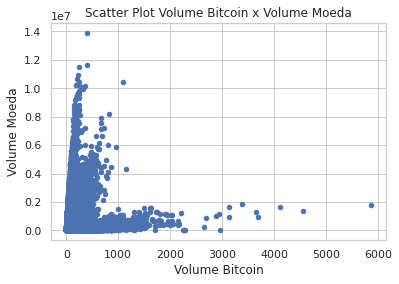

In [43]:
# Scatter Plot Volume Bitcoin x Volume Moeda
plt.figure(figsize = (12,5))
sns.set(style = 'whitegrid')
df_pandas.plot(kind = 'scatter', x = 'VolBTC', y = 'VolCurrency')
plt.xlabel('Volume Bitcoin')            
plt.ylabel('Volume Moeda')
plt.title('Scatter Plot Volume Bitcoin x Volume Moeda') 
plt.show()

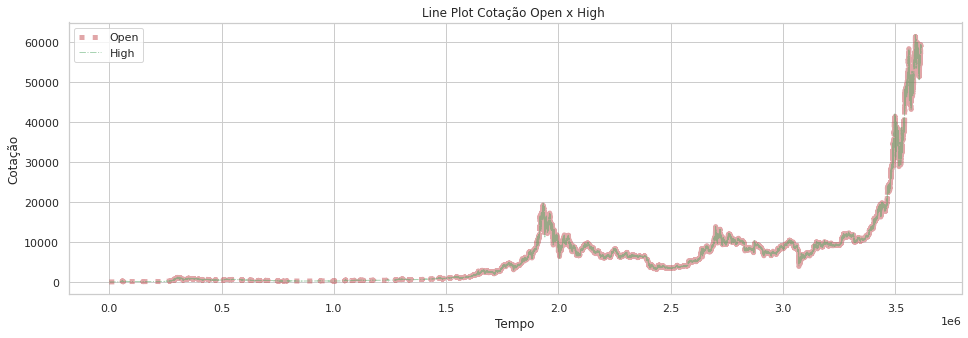

In [44]:
# Line Plot Cotação Open x High 
plt.figure(figsize = (16,5))
df_pandas.Open.plot(kind = 'line', 
                    color = 'r', 
                    label = 'Open', 
                    alpha = 0.5, 
                    linewidth = 5, 
                    grid = True, 
                    linestyle = ':')
df_pandas.High.plot(color = 'g', 
                    label = 'High', 
                    linewidth = 1, 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = '-.')
plt.legend(loc = 'upper left') 
plt.xlabel('Tempo')
plt.ylabel('Cotação')
plt.title('Line Plot Cotação Open x High ')
plt.show()

<AxesSubplot:ylabel='Frequency'>

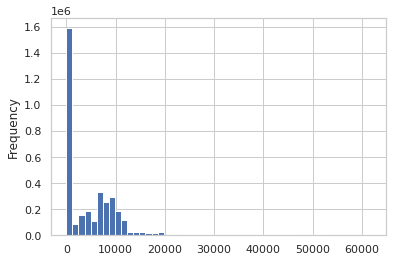

In [45]:
# Histograma da cotação de abertura
df_pandas.Open.plot(kind = 'hist', bins = 50)

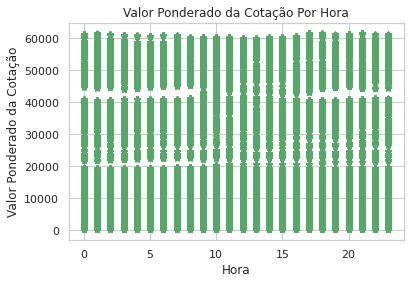

In [46]:
# Plot do valor ponderado da cotação (variável alvo) por hora
plt.plot(hour, weighted_price , 'g*')# g =  color green * simbolo
plt.xlabel('Hora')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Hora') 
plt.show()

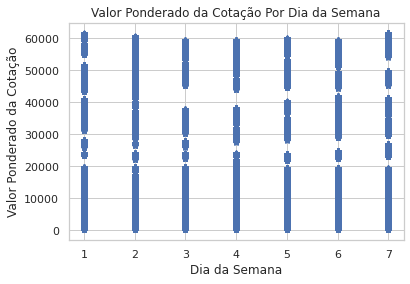

In [47]:
# Plot do valor ponderado da cotação por dia da semana
plt.plot(date_of_week, weighted_price, 'b*')
plt.xlabel('Dia da Semana')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Dia da Semana') 
plt.show()

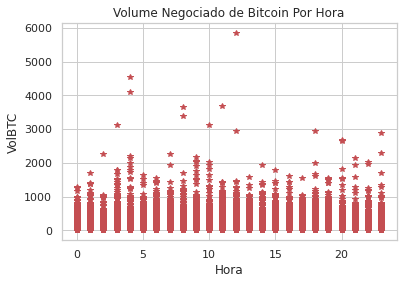

In [48]:
# Plot do VolBTC por hora
plt.plot(hour, volume_BTC, 'r*')
plt.xlabel('Hora')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Hora') 
plt.show()

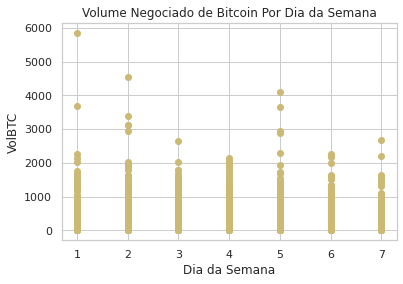

In [49]:
# Plot de VolBTC por dia da semana
plt.plot(date_of_week, volume_BTC, 'yo')
plt.xlabel('Dia da Semana')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Dia da Semana') 
plt.show()

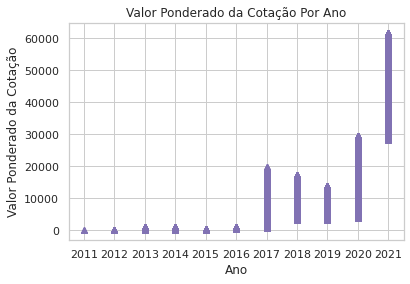

In [50]:
# Plot do valor ponderado da cotação por ano
plt.plot(year, weighted_price , 'm^')
plt.xlabel('Ano')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Ano') 
plt.show()

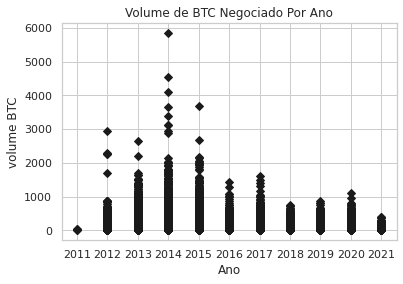

In [51]:
# Plot do Volume por ano
plt.plot(year, volume_BTC , 'kD')
plt.xlabel('Ano')            
plt.ylabel('volume BTC')
plt.title('Volume de BTC Negociado Por Ano') 
plt.show()

## Engenharia de atributos

In [52]:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



In [53]:
# Prepara o vetor de atributos
assembler = VectorAssembler(inputCols = ['Open', 'VolBTC', 'VolCurrency'], 
                            outputCol = "features")

In [54]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_bitcoin)

In [55]:
# Visualiza os dados
df_assembled.show(10, truncate = False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                      |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 04:52:00|[4.39,0.45558087,2.0000000193]|
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 12:50:00|[4.39,48.0,210.72]            |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 13:59:00|[4.5,37.86229723,171.38033753]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 14:00:00|[4.58,9.0,41.22]              |
|1325391360|4.58|4.58|4.58|4.58 |1.502      |6.87916     |4.58          |2012-01-01 01:16:00|[4.58,1.502,6.87916]          |


## Normalização

In [56]:
# Divisão em dados de treino e teste
dados_treino, dados_teste = df_assembled.randomSplit([.7,.3], seed = rnd_seed)

In [57]:
type(dados_treino)

pyspark.sql.dataframe.DataFrame

In [58]:
# Cria o scaler
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

In [59]:
# Fit nos dados de treino
scalerModel = scaler.fit(dados_treino)

In [60]:
# Fit e transform nos dados de treino
dados_treino_scaled = scalerModel.transform(dados_treino)

In [61]:
# Transform nos dados de teste
dados_teste_scaled = scalerModel.transform(dados_teste)

In [62]:
dados_treino_scaled.select("features", "scaled_features").show(10, truncate = False)

+-------------------------------+-------------------------------------------------------------------+
|features                       |scaled_features                                                    |
+-------------------------------+-------------------------------------------------------------------+
|[4.39,48.0,210.72]             |[9.557729822093386E-6,0.008199728766573702,1.51589789206087E-5]    |
|[4.5,37.86229723,171.38033753] |[1.1339679449941311E-5,0.006467928495112392,1.2328924278777876E-5] |
|[4.58,9.0,41.22]               |[1.263564281564889E-5,0.001537449143732569,2.9653241795154263E-6]  |
|[4.84,10.0,48.4]               |[1.6847523754198516E-5,0.001708276826369521,3.4818459555688167E-6] |
|[5.0,10.1,50.5]                |[1.9439450485613674E-5,0.0017253595946332162,3.63291778421953E-6]  |
|[5.14,0.68,3.4952]             |[2.170738637560193E-5,1.1616282419312745E-4,2.5144107404760596E-7] |
|[5.26,29.31939163,154.21999997]|[2.36513314241633E-5,0.00500856372847815,1.109442

In [63]:
dados_treino_scaled.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

## Machine Learning

> Versão 1 do Modelo (Benchmark)

In [64]:
# Cria o modelo de regressão
modelo_lr_v1 = (LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price', 
                                 maxIter = 100, 
                                 regParam = 0.3, 
                                 elasticNetParam = 0.8, 
                                 standardization = False))

In [65]:
# Treina o modelo
modelo_v1 = modelo_lr_v1.fit(dados_treino_scaled)

Se tiver mensagem de WARN, isso indica que o Spark não encontrou a biblioteca de otimização de álgebra linear (que precisa ser instalada, mas não é requerida para este projeto). Mais detalhes aqui:

https://spark.apache.org/docs/latest/ml-linalg-guide.html

In [66]:
# Salva o modelo em disco
modelo_v1.write().overwrite().save("modelos/modelo_v1")

## Avaliação do Modelo

In [67]:
# Previsões com dados de teste
previsoes_v1 = modelo_v1.transform(dados_teste_scaled)

In [68]:
# Seleciona as colunas
pred_data_v1 = previsoes_v1.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|7.452060192894729|          4.39|
|7.641960478636686|          4.58|
|8.061740057645222|           5.0|
|8.381572117842202|          5.32|
|8.351587862198736|          5.29|
|8.351587862198736|          5.29|
| 8.25164034338718|          5.19|
|8.421551125366825|  5.3604618117|
|8.811346448731895|   5.777027027|
|9.061215245760785|           6.0|
+-----------------+--------------+
only showing top 10 rows



In [69]:
# Mean Absolute Error
print("Mean Absolute Error (MAE) nos dados de teste: {0}".format(modelo_v1.summary.meanAbsoluteError))

Mean Absolute Error (MAE) nos dados de teste: 5.017385733181623


In [70]:
# Cria um avaliador para o modelo de regressão
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [71]:
# Aplica o avaliador
rmse_v1 = evaluator.evaluate(previsoes_v1)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v1)

Root Mean Squared Error (RMSE) nos dados de teste = 11.2879


In [72]:
# Extrai as previsões
pred_results_v1 = modelo_v1.evaluate(dados_teste_scaled)

In [73]:
# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v1.predictions.select('Weighted_Price').toPandas()

In [74]:
# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v1.predictions.select("Predicted_price").toPandas()

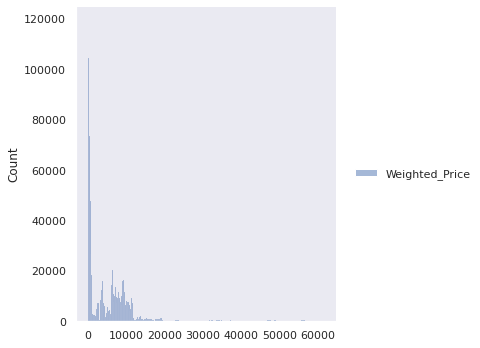

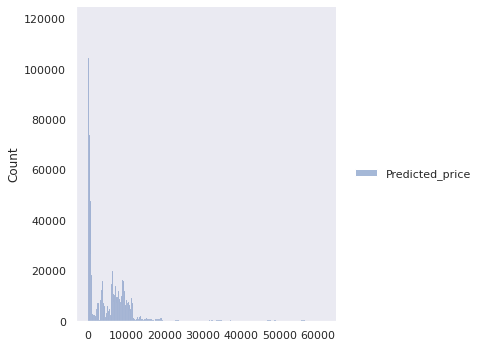

In [75]:
# Distribuição dos valores reais x valores previstos
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

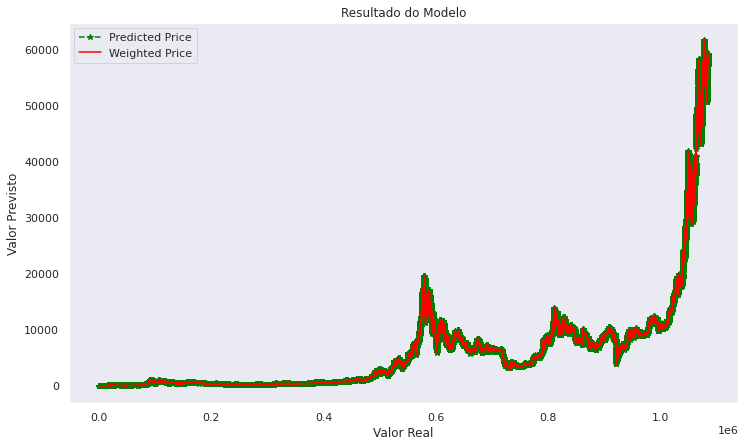

In [76]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

> Versão 2 do Modelo (Otimização de Hiperparâmetros)

In [78]:
# Cria o modelo
modelo_lr_v2 = (LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price'))

In [79]:
# Cria um grid para otimização de hiperparâmetros
grid = ParamGridBuilder().addGrid(modelo_lr_v2.maxIter, [50, 100]).build()

In [80]:
# Cria o avaliador (será usado na validação cruzada)
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [81]:
# Cria o CrossValidator
cv = CrossValidator(estimator = modelo_lr_v2, estimatorParamMaps = grid, evaluator = evaluator, parallelism = 2)

In [82]:
# Treina o CrossValidator
cvModel = cv.fit(dados_treino_scaled)

22/09/12 19:16:00 WARN Instrumentation: [cd851fb0] regParam is zero, which might cause numerical instability and overfitting.
22/09/12 19:16:00 WARN Instrumentation: [17f48e40] regParam is zero, which might cause numerical instability and overfitting.


22/09/12 19:16:19 WARN MemoryStore: Not enough space to cache rdd_152_7 in memory! (computed 41.7 MiB so far)
22/09/12 19:16:19 WARN MemoryStore: Not enough space to cache rdd_152_4 in memory! (computed 41.7 MiB so far)
22/09/12 19:16:19 WARN BlockManager: Persisting block rdd_152_7 to disk instead.
22/09/12 19:16:19 WARN BlockManager: Persisting block rdd_152_4 to disk instead.
22/09/12 19:16:19 WARN MemoryStore: Not enough space to cache rdd_152_1 in memory! (computed 41.8 MiB so far)
22/09/12 19:16:19 WARN BlockManager: Persisting block rdd_152_1 to disk instead.


22/09/12 19:16:46 WARN Instrumentation: [7c604471] regParam is zero, which might cause numerical instability and overfitting.
22/09/12 19:16:46 WARN Instrumentation: [04620a73] regParam is zero, which might cause numerical instability and overfitting.


22/09/12 19:17:00 WARN MemoryStore: Not enough space to cache rdd_250_1 in memory! (computed 41.8 MiB so far)
22/09/12 19:17:00 WARN BlockManager: Persisting block rdd_250_1 to disk instead.


22/09/12 19:17:18 WARN Instrumentation: [807f17b0] regParam is zero, which might cause numerical instability and overfitting.
22/09/12 19:17:18 WARN Instrumentation: [baac66aa] regParam is zero, which might cause numerical instability and overfitting.


22/09/12 19:17:31 WARN MemoryStore: Not enough space to cache rdd_348_5 in memory! (computed 41.7 MiB so far)
22/09/12 19:17:31 WARN BlockManager: Persisting block rdd_348_5 to disk instead.


22/09/12 19:17:48 WARN Instrumentation: [33db5c06] regParam is zero, which might cause numerical instability and overfitting.


In [83]:
# Extrai o melhor modelo do CrossValidator
modelo_v2 = cvModel.bestModel

In [84]:
# Salva o modelo em disco
modelo_v2.write().overwrite().save("modelos/modelo_v2")

## Avaliação do Modelo

In [85]:
# Previsões com dados de teste
previsoes_v2 = modelo_v2.transform(dados_teste_scaled)

In [86]:
# Seleciona as colunas
pred_data_v2 = previsoes_v2.select("Predicted_price", "Weighted_Price").show(10)

+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
| 4.508108472357593|          4.39|
| 4.697545264575934|          4.58|
| 5.108091101746675|           5.0|
| 5.437041429505176|          5.32|
| 5.392532805262221|          5.29|
| 5.402256707831288|          5.29|
|5.3069234754546475|          5.19|
| 5.470987379974378|  5.3604618117|
| 5.860328227652778|   5.777027027|
| 6.117129927737251|           6.0|
+------------------+--------------+
only showing top 10 rows



In [87]:
# Mean Absolute Error
print("MAE: {0}".format(modelo_v2.summary.meanAbsoluteError))

MAE: 3.388028733539672


In [88]:
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [89]:
# Aplica o avaliador
rmse_v2 = evaluator.evaluate(previsoes_v2)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v2)

Root Mean Squared Error (RMSE) nos dados de teste = 10.3524


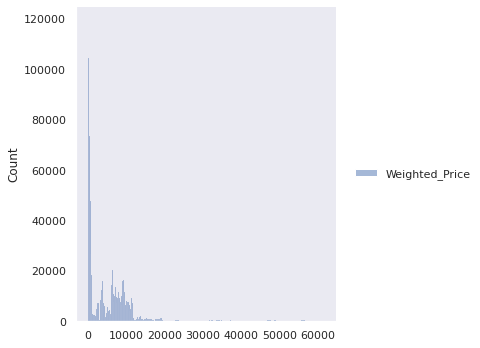

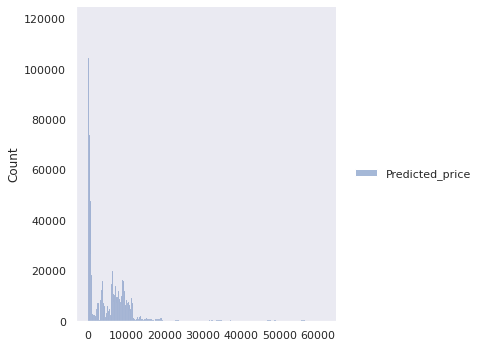

In [90]:
# Plot dos valores reais x valores previstos

# Extrai as previsões
pred_results_v2 = modelo_v2.evaluate(dados_teste_scaled)

# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v2.predictions.select('Weighted_Price').toPandas()

# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v2.predictions.select("Predicted_price").toPandas()

# Plot
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

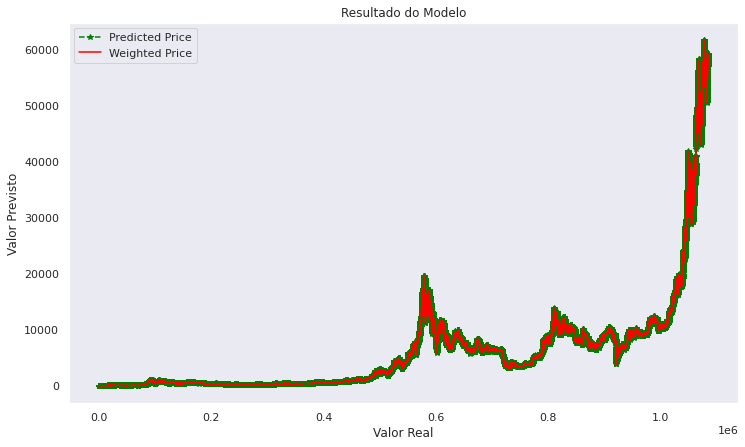

In [91]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

As mensagens de WARN no treinamento do modelo_v2 indicam que o modelo parece instável e talvez esteja com overfitting. Usaremos o modelo_v1.

## Previsões em Tempo Real

In [92]:
# Novos dados
novos_dados = [[21836, 2469.67, 54656477.14], [21663, 844.39, 18257741.52]]

In [93]:
# Prepara o dataframe do Pandas
df_novos_dados = pd.DataFrame(novos_dados, columns = ['Open', 'VolBTC', 'VolCurrency'])

In [94]:
# Visualiza
df_novos_dados

,Open,VolBTC,VolCurrency
0,21836,2469.67,54656477.14
1,21663,844.39,18257741.52


In [95]:
# Converte o dataframe do Pandas para dataframe do Spark
df_novos_dados_spark = spark_session.createDataFrame(df_novos_dados) 

In [96]:
# Schema
df_novos_dados_spark.printSchema()

root
 |-- Open: long (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)



In [97]:
# Visualiza
df_novos_dados_spark.show()

+-----+-------+-------------+
| Open| VolBTC|  VolCurrency|
+-----+-------+-------------+
|21836|2469.67|5.465647714E7|
|21663| 844.39|1.825774152E7|
+-----+-------+-------------+



In [98]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_novos_dados_spark)

In [99]:
# Visualiza os dados
df_assembled.show()

+-----+-------+-------------+--------------------+
| Open| VolBTC|  VolCurrency|            features|
+-----+-------+-------------+--------------------+
|21836|2469.67|5.465647714E7|[21836.0,2469.67,...|
|21663| 844.39|1.825774152E7|[21663.0,844.39,1...|
+-----+-------+-------------+--------------------+



In [100]:
# Normaliza os dados
df_assembled_scaled = scalerModel.transform(df_assembled)

In [101]:
# Previsões com os novos dados
previsoes = modelo_v1.transform(df_assembled_scaled)

In [102]:
# Imprime as previsões
pred_data = previsoes.select("Predicted_price").show()

+------------------+
|   Predicted_price|
+------------------+
|  21827.6045718085|
|21654.695364264513|
+------------------+



In [103]:
# Encerra a sessão Spark
spark_session.stop()

# Fim